# Chapter 3. Classification

## MNIST
Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']
print('X size', X.shape)
print('label size:', y.shape)

X size (70000, 784)
label size: (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s `imshow()` function:

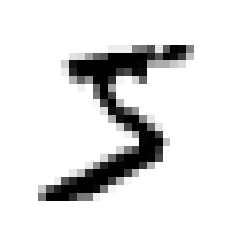

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digits_image = some_digit.reshape(28, 28)

plt.imshow(some_digits_image, cmap='binary')
plt.axis("off")
plt.show()

In [7]:
print(y[0])

5


In [8]:
# Let's cast labels as integers
import numpy as np

y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's try to identify only one digit "5". This will be an example of _binary classifier_, capable of distibuishing between just two classes, 5 and not-5.

In [10]:
# Set for all 5s
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a _Stochastic Gradient Descent (SGD)_ classifier. This classifier deals with large datasets efficiently, because it deals with training instances independetly, one at a time.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Predicting if the digit is 5
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation
Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluatingthem on each fold using a model trained on the remaining folds.

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

before we get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with _skewed datasets_.

### Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. The `cross_val_predict()`
performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set.

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Let's get the confusion matrix and pass the target classes and the predicted classes

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an _actual class_, while each column represents a _predicted class_. The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining1,522 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives).

An interesting one to look at the accuracy of the positive predictions; this is called the precision of the classifier. _precision_= $\frac{TP}{TP+FP}$. $TP$ is the number of true positives, and $FP$ is the number of false positives.

precision is typically used along with another metric named _recall_, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier. _recall_=$\frac{TP}{TP+FN}$. $FN$ is the number of false negatives.